In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
tf.random.set_seed(42)
np.random.seed(42)

In [3]:
from tensorflow.keras.datasets import mnist

# Load the dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the images (pixel values from 0–255 → 0–1)
x_train = x_train / 255.0
x_test = x_test / 255.0

# Flatten the images: 28x28 → 784
x_train = x_train.reshape(-1, 28 * 28)
x_test = x_test.reshape(-1, 28 * 28)

# One-hot encode the labels (e.g. 3 → [0 0 0 1 0 0 0 0 0 0])
y_train = tf.one_hot(y_train, depth=10)
y_test = tf.one_hot(y_test, depth=10)

# Convert everything to float32 tensors
x_train = tf.convert_to_tensor(x_train, dtype=tf.float32)
x_test = tf.convert_to_tensor(x_test, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)


In [4]:
# Define hyperparameters for the network architecture
input_size = 784
hidden_layer_1_size = 512
hidden_layer_2_size = 128
output_size = 10

In [5]:
# Initialize weights and biases for the first hidden layer (Input to H1)
W1 = tf.Variable(tf.random.normal([input_size, hidden_layer_1_size], stddev=0.1), name="W1")
b1 = tf.Variable(tf.zeros([hidden_layer_1_size]), name="b1")

# Initialize weights and biases for the second hidden layer (H1 to H2)
W2 = tf.Variable(tf.random.normal([hidden_layer_1_size, hidden_layer_2_size], stddev=0.1), name="W2")
b2 = tf.Variable(tf.zeros([hidden_layer_2_size]), name="b2")

# Initialize weights and biases for the output layer (H2 to Output)
W3 = tf.Variable(tf.random.normal([hidden_layer_2_size, output_size], stddev=0.1), name="W3")
b3 = tf.Variable(tf.zeros([output_size]), name="b3")

In [6]:
print("Weights and biases for MLP with two hidden layers initialized:")
print(f"W1 shape: {W1.shape}, b1 shape: {b1.shape}")
print(f"W2 shape: {W2.shape}, b2 shape: {b2.shape}")
print(f"W3 shape: {W3.shape}, b3 shape: {b3.shape}")

Weights and biases for MLP with two hidden layers initialized:
W1 shape: (784, 512), b1 shape: (512,)
W2 shape: (512, 128), b2 shape: (128,)
W3 shape: (128, 10), b3 shape: (10,)


In [7]:
def forward_pass(x):
    # First hidden layer
    z1 = tf.matmul(x, W1) + b1
    a1 = tf.math.sigmoid(z1)

    # Second hidden layer
    z2 = tf.matmul(a1, W2) + b2
    a2 = tf.math.sigmoid(z2)

    # Output layer
    z3 = tf.matmul(a2, W3) + b3
    output = tf.nn.softmax(z3)

    return output


In [8]:
def compute_loss(y_true, y_pred):
    # Clip values to avoid log(0) error
    y_pred = tf.clip_by_value(y_pred, 1e-10, 1.0)
    loss = -tf.reduce_mean(tf.reduce_sum(y_true * tf.math.log(y_pred), axis=1))
    return loss


In [9]:
def compute_accuracy(y_true, y_pred):
    correct_preds = tf.equal(tf.argmax(y_true, axis=1), tf.argmax(y_pred, axis=1))
    accuracy = tf.reduce_mean(tf.cast(correct_preds, tf.float32))
    return accuracy


In [10]:
def train_step(x_batch, y_batch, learning_rate=0.1):
    with tf.GradientTape() as tape:
        y_pred = forward_pass(x_batch)
        loss = compute_loss(y_batch, y_pred)

    # Compute gradients w.r.t. all trainable variables
    grads = tape.gradient(loss, [W1, b1, W2, b2, W3, b3])

    # Apply gradient descent manually
    W1.assign_sub(learning_rate * grads[0])
    b1.assign_sub(learning_rate * grads[1])
    W2.assign_sub(learning_rate * grads[2])
    b2.assign_sub(learning_rate * grads[3])
    W3.assign_sub(learning_rate * grads[4])
    b3.assign_sub(learning_rate * grads[5])

    return loss


In [11]:
epochs = 10
batch_size = 128
train_losses = []
test_losses = []
test_accuracies = []

for epoch in range(epochs):
    # Shuffle training data
    indices = np.arange(x_train.shape[0])
    np.random.shuffle(indices)
    indices_tf = tf.convert_to_tensor(indices, dtype=tf.int32)
    x_train = tf.gather(x_train, indices_tf)
    y_train = tf.gather(y_train, indices_tf)

    # Mini-batch training
    for i in range(0, x_train.shape[0], batch_size):
        x_batch = x_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]
        loss = train_step(x_batch, y_batch)

    # Compute loss and accuracy on train and test sets
    y_train_pred = forward_pass(x_train)
    y_test_pred = forward_pass(x_test)

    train_loss = compute_loss(y_train, y_train_pred).numpy()
    test_loss = compute_loss(y_test, y_test_pred).numpy()
    test_acc = compute_accuracy(y_test, y_test_pred).numpy()

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Epoch 1, Train Loss: 0.6293, Test Loss: 0.6151, Test Accuracy: 0.8444
Epoch 2, Train Loss: 0.4188, Test Loss: 0.4034, Test Accuracy: 0.8907
Epoch 3, Train Loss: 0.3577, Test Loss: 0.3443, Test Accuracy: 0.9000
Epoch 4, Train Loss: 0.3257, Test Loss: 0.3131, Test Accuracy: 0.9102
Epoch 5, Train Loss: 0.3079, Test Loss: 0.2971, Test Accuracy: 0.9135
Epoch 6, Train Loss: 0.2929, Test Loss: 0.2825, Test Accuracy: 0.9188
Epoch 7, Train Loss: 0.2800, Test Loss: 0.2728, Test Accuracy: 0.9189
Epoch 8, Train Loss: 0.2671, Test Loss: 0.2612, Test Accuracy: 0.9247
Epoch 9, Train Loss: 0.2565, Test Loss: 0.2510, Test Accuracy: 0.9255
Epoch 10, Train Loss: 0.2484, Test Loss: 0.2439, Test Accuracy: 0.9293


In [12]:
print(f"Final Test Accuracy: {test_accuracies[-1]:.4f}")

Final Test Accuracy: 0.9293


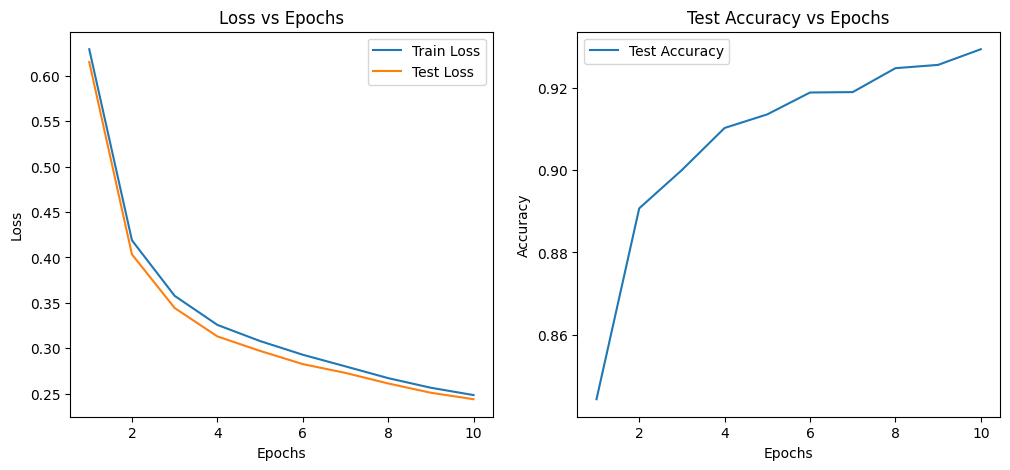

In [13]:
import matplotlib.pyplot as plt

epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Test Accuracy vs Epochs')
plt.legend()

plt.show()
